# LFADS
This notebook is part of the [SachsLab Workshop for Intracranial Neurophysiology and Deep Learning](https://github.com/SachsLab/IntracranialNeurophysDL).

Follow the link below to run in Google Colab or continue if running locally.

Run the first few cells to normalize Local / Colab environments, then proceed below for the lesson.

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/SachsLab/IntracranialNeurophysDL/blob/master/notebooks/06_01_LFADS.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/SachsLab/IntracranialNeurophysDL/blob/master/notebooks/06_01_LFADS.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>


In [1]:
import os
import sys
from pathlib import Path
try:
    # See if we are running on google.colab
    import google.colab
    from google.colab import files
    if sys.version_info > (3, 0):
        from importlib import reload
        !pip install --upgrade -q https://storage.googleapis.com/jax-wheels/cuda$(echo $CUDA_VERSION | sed -e 's/\.//' -e 's/\..*//')/jaxlib-latest-cp36-none-linux_x86_64.whl
    else:
        !pip install --upgrade -q https://storage.googleapis.com/jax-wheels/cuda$(echo $CUDA_VERSION | sed -e 's/\.//' -e 's/\..*//')/jaxlib-latest-cp27-none-linux_x86_64.whl
    !pip install --upgrade -q git+https://github.com/google/jax.git

    os.chdir('..')
    if not (Path.home() / '.kaggle').is_dir():
        # Configure kaggle
        files.upload()  # Find the kaggle.json file in your ~/.kaggle directory.
        !pip install -q kaggle
        !mkdir -p ~/.kaggle
        !mv kaggle.json ~/.kaggle/
        !chmod 600 ~/.kaggle/kaggle.json
    if Path.cwd().stem != 'IntracranialNeurophysDL':
        if not (Path.cwd() / 'IntracranialNeurophysDL').is_dir():
            # Download the workshop repo and change to its directory
            !git clone --recursive https://github.com/SachsLab/IntracranialNeurophysDL.git
        os.chdir('IntracranialNeurophysDL')
    IN_COLAB = True
except ModuleNotFoundError:
    IN_COLAB = False
    if Path.cwd().stem == 'notebooks':
        os.chdir(Path.cwd().parent)
    # Make sure the kaggle executable is on the PATH
    os.environ['PATH'] = os.environ['PATH'] + ';' + str(Path(sys.executable).parent / 'Scripts')


In [2]:
# Download and unzip data (2.1 GB)
datadir = Path.cwd() / 'data' / 'joeyo'
if not (datadir / 'converted').is_dir():
    !kaggle datasets download --unzip --path {str(datadir / 'converted')} cboulay/joeyo_nhp_reach_mea
    print("Finished downloading and extracting data.")
else:
    print("Data directory found. Skipping download.")


Data directory found. Skipping download.


## Imports


In [3]:
import jax.numpy as np
from jax import jit, random, vmap, grad, lax
from jax.experimental import optimizers
#config.update("jax_debug_nans", True) # Useful for finding numerical errors
import matplotlib.pyplot as plt
import numpy as onp  # original CPU-backed NumPy
import time


## Randomization
> JAX uses its own setup to handle randomness and seeding the pseudo-random number generators.
You can read about it [here](https://github.com/google/jax/blob/master/README.md#random-numbers-are-different).


In [4]:
MAX_SEED_INT = 10000000
key = random.PRNGKey(onp.random.randint(0, MAX_SEED_INT))


## Get Data
Unlike notebook 05_02, where we used a small number of wide bins per sequence,
here we use a large number of narrow bins per sequence, where a sequence corresponds to an entire trial
from target onset to target hit (and a bit beyond for short trials).
### Data Hyperparameters


In [5]:
SESS_IDX = 7          # Index of recording session we will use. 0:8
MAX_TRIAL_DUR = 1.7   # This gets rid of about 7% of the slowest trials (long tail distribution)
BIN_DURATION = 0.020  # Width of window used to bin spikes, in seconds
P_TRAIN = 0.8         # Proportion of data used for training.


### Load Spiking Data


In [6]:
from data.utils.fileio import load_joeyo_reaching

def load_dat_with_vel_accel(datadir, sess_idx, x_chunk='mu_spiketimes', trial_dur=1.7):
    BEHAV_CHANS = ['CursorX', 'CursorY']
    sess_names = ['indy_201' + _ for _ in ['60921_01', '60927_04', '60927_06', '60930_02', '60930_05', '61005_06',
                                           '61006_02', '70124_01', '70127_03']]
    X, Y, X_ax_info, Y_ax_info = load_joeyo_reaching(datadir, sess_names[sess_idx], x_chunk=x_chunk)

    # Determine target onset times that we will keep.
    targ_ch_ix = onp.where(onp.in1d(Y_ax_info['channel_names'], ['TargetX', 'TargetY']))[0]
    b_targ_onset = onp.hstack((True, onp.any(onp.diff(Y[targ_ch_ix]) != 0, axis=0)))
    targ_onset_times = Y_ax_info['timestamps'][b_targ_onset]
    b_short_trials = onp.hstack((onp.diff(targ_onset_times) <= trial_dur, False))
    print("Keeping {} of {} trials ({} %) shorter than {} s.".format(onp.sum(b_short_trials),
                                                                    b_short_trials.size,
                                                                    100 * onp.sum(b_short_trials) / b_short_trials.size,
                                                                    trial_dur))
    targ_onset_times = targ_onset_times[b_short_trials]

    # Slice Y to only keep required behaviour data (cursor position)
    b_keep_y_chans = onp.in1d(Y_ax_info['channel_names'], BEHAV_CHANS)
    Y = Y[b_keep_y_chans, :]
    Y_ax_info['channel_names'] = [_ for _ in Y_ax_info['channel_names'] if _ in BEHAV_CHANS]

    # Calculate discrete derivative and double-derivative to get velocity and acceleration.
    vel = onp.diff(Y, axis=1)
    vel = onp.concatenate((vel[:, 0][:, None], vel),
                         axis=1)  # Assume velocity was constant across the first two samples.
    accel = onp.concatenate(([[0], [0]], np.diff(vel, axis=1)), axis=1)  # Assume accel was 0 in the first sample.
    Y = onp.concatenate((Y, vel, accel), axis=0)
    Y_ax_info['channel_names'] += ['VelX', 'VelY', 'AccX', 'AccY']

    return X, Y, X_ax_info, Y_ax_info, targ_onset_times

X, Y, X_ax_info, Y_ax_info, targ_times = load_dat_with_vel_accel(datadir, SESS_IDX, trial_dur=MAX_TRIAL_DUR)


Keeping 463 of 487 trials (95.07186858316221 %) shorter than 1.7 s.


### Segment Into Trials 


In [7]:
def bin_and_segment_spike_times(X, X_ax_info, targ_onset_times,
                                nearest_bin_dur=0.005, nearest_bin_step_dur=None, trial_dur=1.7):

    # We'll use an integer number of samples per bin: the next highest required to get the requested nearest_bin_dur
    samps_per_bin = int(onp.ceil(nearest_bin_dur * X_ax_info['fs']))
    true_bin_dur = samps_per_bin / X_ax_info['fs']
    print("Actual bin duration: {}".format(true_bin_dur))

    # Similar for number of samples per bin-step.
    if nearest_bin_step_dur is not None:
        samps_per_step = int(onp.ceil(nearest_bin_step_dur * X_ax_info['fs']))
        print("Actual bin duration: {}".format(samps_per_bin / X_ax_info['fs']))
    else:
        # No overlap
        samps_per_step = samps_per_bin

    # Get the indices of each bin-start
    bin_starts_idx = onp.arange(0, X.shape[-1], samps_per_step)
    b_full_bins = bin_starts_idx <= (X.shape[-1] - samps_per_bin)
    bin_starts_idx = bin_starts_idx[b_full_bins]

    # The next chunk of code counts the number of spikes in each bin.
    # -Create array of indices to reslice the raster data
    bin_ix = onp.arange(samps_per_bin)[:, None] + bin_starts_idx[None, :]
    # -Create buffer to hold the dense raster data
    _temp = onp.zeros(X[0].shape, dtype=bool)
    # -Preallocate _X to hold spike counts per bin
    _X = onp.zeros((len(bin_starts_idx), X.shape[0]), dtype=np.int32)
    for chan_ix in range(X.shape[0]):
        _X[:, chan_ix] = np.sum(X[chan_ix].toarray(out=_temp)[0][bin_ix], axis=0)

    # Now that our data are binned, let's slice it up into trials.
    bins_per_trial = int(trial_dur / true_bin_dur)
    trial_X = onp.zeros((len(targ_onset_times), bins_per_trial, _X.shape[-1]))

    bin_stops_t = X_ax_info['timestamps'][bin_starts_idx + samps_per_bin - 1]
    trial_starts_idx = onp.searchsorted(bin_stops_t, targ_onset_times)
    for trial_ix, t_start_idx in enumerate(trial_starts_idx):
        trial_X[trial_ix] = _X[t_start_idx:t_start_idx+bins_per_trial, :]

    in_trial_tvec = onp.arange(bins_per_trial) * true_bin_dur

    return trial_X, in_trial_tvec, true_bin_dur

trial_X, trial_tvec, true_bin_dur = bin_and_segment_spike_times(X, X_ax_info, targ_times,
                                                                nearest_bin_dur=BIN_DURATION, trial_dur=MAX_TRIAL_DUR)

Actual bin duration: 0.02048


### Split Train and Validation


In [8]:
from sklearn.model_selection import train_test_split
X_train, X_valid = train_test_split(trial_X, train_size=P_TRAIN)


### Visualize Data


trial_X has 463 trials, 83 bin-steps per trial, and 91 neurons.


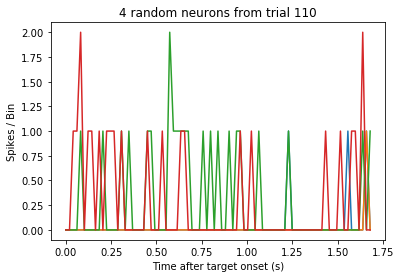

In [10]:
fig = plt.figure(facecolor='white')

n_trials, n_timesteps, n_neurons = trial_X.shape
print("trial_X has {} trials, {} bin-steps per trial, and {} neurons.".format(n_trials, n_timesteps, n_neurons))
trial_idx = onp.random.randint(0, n_trials-1, 1)[0]
neuron_idx = onp.random.randint(0, n_neurons-1, 4)
plt.plot(trial_tvec, trial_X[trial_idx, :, neuron_idx].T)
plt.title("{} random neurons from trial {}".format(len(neuron_idx), trial_idx))
plt.xlabel('Time after target onset (s)')
plt.ylabel('Spikes / Bin')

plt.show()


## LFADS - Latent Factor Analysis via Dynamical Systems
The rest of this notebook is based on a notebook and supporting code found in in the
[google-research/computation-thru-dynamics github repo](https://github.com/google-research/computation-thru-dynamics).

The LFADS model is summarized in the below diagram. For now we will ignore the bottom "Controller" and "Inferred inputs" parts.

![](https://raw.githubusercontent.com/google-research/computation-thru-dynamics/master/images/lfads_architecture_w_inferred_inputs_3.png)

The model is described in commented pseudocode below.

In [14]:
# Our data is of shape n_trials x n_bins_per_trial (aka timesteps) x n_neurons.
# The batched_data is a list of data of shape n_trials_per_batch x n_bins_per_trial x n_neurons
# Here we initialize it with an empty list just so we don't trigger errors when trying to run this cell.
batched_data = []

# For each batch of binned spike counts
for binned_spike_counts in batched_data:
    
    ##################
    ## ENCODER PART ##
    
    # Randomly drop out spikes. Re-randomized for each time-step!
    do_binned_spike_counts = Dropout(binned_spike_counts)
    
    # Run the data through a nonlinear recurrent **encoder**. They use a Bidirectional GRU layer.
    # n_neurons -> 2 * ENC_DIM
    full_enc_fwd_bkwd, enc_ends_fwd_last_bkwd_first = BidirectionalGRU(do_binned_spike_counts)
    # AFAICT, full_enc_fwd_bkwd is only used when calculating inferred inputs.
    
    # Convert the end-points of the RNN output to 'initial conditions', which is the per-trial mean and variance
    # to produce random vectors to encode the trial. This is the 'bottleneck' or 'latent variables' in a VAE.
    # 2 * ENC_DIM -> 2 * GEN_DIM; GEN_DIM for means and GEN_DIM for logvars
    ic_mean_logvar = Dense(Dropout(enc_ends_fwd_last_bkwd_first))
    
    ##################
    ## DECODER PART ##
    
    # The initial state used in the next step is a vector randomly drawn from the distribution calculated above.
    g = initial_state = diag_gaussian_sample(ic_mean_logvar)
    
    # The generator is a GRU that takes as input the initial state.
    # In the tensorflow implementation, this was a slightly specialized GRU: https://github.com/tensorflow/models/blob/c80de2ca3ec34c4d510961b6a604309772fc02ad/research/lfads/lfads.py#L158
    # The output are the "neural modes", aka "latent factors".
    # 2 * GEN_DIM -> FACTORS_DIM
    latent_factors = []
    for step_ix in range(n_bins_per_trial):
        g = GRU(g)
        g = Dropout(g)
        f = normed_linear(g)
        
        latent_factors.append(f)
        
    # The factors are transformed to give 'rates' for as many channels as there were neurons in the binned_spike_counts.
    reconstructed_log_rates = Dense(latent_factors)
    reconstructed_rates = exp(reconstructed_log_rates)
    
    # The rates parameterize a Poisson distribution from which spikes are drawn.
    reconstructed_binned_spike_counts = Poisson(reconstructed_rates)
    
    ##########
    ## LOSS ##
    
    log_p_xgz = mean(log_likelihood(binned_spike_counts, reconstructed_binned_spike_counts))
    loss = -log_p_xgz + kl_loss_g0 + l2_loss
    
    ############
    ## UPDATE ##
    
    # All of the above would be wrapped in a compiled loss_fn called once per batch,
    # then we can use JAX grad to calculate the gradients of that function.
    gradients = grad(loss_fn)
        
    # Then the optimizer updates the model weights using the gradients.
    optimizer_update(gradients)
    

## LFADS Hyperparameters

In the above pseudocode the dimensions are mentioned but the hyperparameters are omitted.
There are many.

In [10]:
from indl.lfads import utils
from indl.lfads.optimize import get_kl_warmup_fun
import indl.lfads.distributions as dists

BATCH_SIZE = 4        # Number of trials in each training step during optimization
EPOCHS = 10           # Number of loops through the entire data set.

# LFADS architecture
N_RNN_UNITS = 60      # Size of RNN output (state)
ENC_DIM = 128         # encoder dim
CON_DIM = 128         # controller dim
GEN_DIM = 128         # generator dim, should be large enough to generate dynamics
FACTORS_DIM = 32      # factors dim, should be large enough to capture most variance of dynamics

# Numerical stability
VAR_MIN = 0.001               # Minimal variance any gaussian can become.

# Initial state prior parameters
# the mean is set to zero in the code
IC_PRIOR_VAR = 0.1            # this is sigma^2 of uninformative prior

# Inferred input autoregressive prior parameters
# TODO: Remove
ar_mean = 0.0                 # process mean
ar_autocorrelation_tau = 1.0  # seconds, how correlated each time point is, related to $\phi$ above.
ar_noise_variance = 0.1       # noise variance

# Optimization Hyperparameters
num_batches = int(n_trials * EPOCHS / BATCH_SIZE)  # how many batches do we train
print_every = 20              # give information every so often

# Learning rate HPs
STEP_SIZE = 0.05              # initial learning rate
DECAY_FACTOR = 0.995          # learning rate decay param
DECAY_STEPS = 1               # learning rate decay param

# Regularization HPs
P_DROPOUT = 0.05              # Proportion of units to set to 0 on each step.
keep_rate = 1 - P_DROPOUT
L2_REG = 2.0e-5               # Parameter regularization strength.

# Numerical stability HPs
MAX_GRAD_NORM = 10.0          # gradient clipping above this value


### KL Warmup
Copied straight from [LFADS tutorial optimize.py](https://github.com/google-research/computation-thru-dynamics/blob/master/lfads_tutorial/optimize.py).

> It turns out that the KL term can be a lot easier to optimize initially than learning how to
reconstruct your data. This results in a pathological stoppage of training where the KL goes to
nearly zero and training is broken there on out (as you cannot represent any a given trial from
uninformative priors). One way out of this is to warmup the KL penality, starting it off with a
weight term of 0 and then slowly building to 1, giving the reconstruction a chance to train a bit
without the KL penalty messing things up.


In [11]:
kl_warmup_start = 50.0 # batch number to start kl warmup, explicitly float
kl_warmup_end = 250.0  # batch number to be finished with kl warmup, explicitly float
kl_min = 0.01 # The minimum KL value, non-zero to make sure KL doesn't grow crazy before kicking in.
kl_max = 1.0


Text(0.5, 0, 'Training batch')

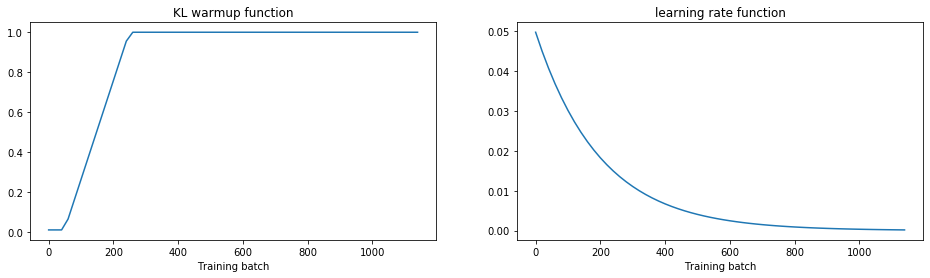

In [14]:
# Plot the warmup function and the learning rate decay function.
plt.figure(figsize=(16,4), facecolor='white')
plt.subplot(1, 2, 1)
x = onp.arange(0, num_batches, print_every)
kl_warmup_fun = get_kl_warmup_fun(lfads_opt_hps)
plt.plot(x, [kl_warmup_fun(i) for i in onp.arange(1, num_batches, print_every)]);
plt.title('KL warmup function')
plt.xlabel('Training batch')

plt.subplot(1, 2, 2)
decay_fun = optimizers.exponential_decay(STEP_SIZE, DECAY_STEPS, DECAY_STEPS)
plt.plot(x, [decay_fun(i) for i in range(1, num_batches, print_every)])
plt.title('learning rate function')
plt.xlabel('Training batch') 


### Collect hyperparams


In [12]:
from indl.lfads.lfads import lfads_params
lfads_hps = {'data_dim' : n_neurons, 'ntimesteps' : n_timesteps,
             'enc_dim' : ENC_DIM, 'con_dim' : CON_DIM, 'var_min' : VAR_MIN,
             'ic_prior_var' : IC_PRIOR_VAR, 'ar_mean' : ar_mean,
             'ar_autocorrelation_tau' : ar_autocorrelation_tau,
             'ar_noise_variance' : ar_noise_variance,
             'ii_dim' : II_DIM, 'gen_dim' : GEN_DIM,
             'factors_dim' : FACTORS_DIM,
             'l2reg' : L2_REG,
             'batch_size' : BATCH_SIZE}

lfads_opt_hps = {'num_batches' : num_batches, 'step_size' : STEP_SIZE,
                 'decay_steps' : DECAY_STEPS, 'decay_factor' : DECAY_FACTOR,
                 'kl_min' : kl_min, 'kl_max' : kl_max, 'kl_warmup_start' : kl_warmup_start,
                 'kl_warmup_end' : kl_warmup_end, 'keep_rate' : keep_rate,
                 'max_grad_norm' : MAX_GRAD_NORM, 'print_every' : print_every,
                 'adam_b1' : 0.9, 'adam_b2' : 0.999, 'adam_eps' : 1e-1}

init_params = lfads_params(key, lfads_hps)


## Define LFADS functions

Some of the functions we should already be familiar with are imported from a helper module in the workshop repository.

Here we define some new functions and the "layers".
* JAX has a very lightweight interface for NN layers

Some of these functions are copied directly from the LFADS tutorial [here](https://github.com/google-research/computation-thru-dynamics/blob/master/lfads_tutorial/lfads.py), with a bit of cleaning up and trimming comments for familiar things.

In [ ]:
def gru(params, h, x, bfg=0.5):
    """
    Implement the GRU equations.
    
    Arguments:
    params: dictionary of GRU parameters
    h: np array of hidden state
    x: np array of input
    bfg: bias on forget gate (useful for learning if > 0.0)
    
    Returns:
    np array of hidden state after GRU update
    """
    hx = np.concatenate([h, x], axis=0)
    ru = sigmoid(np.dot(params['wRUHX'], hx) + params['bRU'])
    r, u = np.split(ru, 2, axis=0)
    rhx = np.concatenate([r * h, x])
    c = np.tanh(np.dot(params['wCHX'], rhx) + params['bC'] + bfg)
    return u * h + (1.0 - u) * c


def run_gru(params, x_t, h0=None):
    """
    Run an GRU module forward in time.
    
    Arguments:
    params: dictionary of RNN parameters
    x_t: np array data for RNN input with leading dim being time
    h0: initial condition for running rnn, which overwrites param h0
    
    Returns:
    np array of rnn applied to time data with leading dim being time
    """
    h = h0 if h0 is not None else params['h0']
    h_t = []
    for x in x_t:
        h = gru(params, h, x)
        h_t.append(h)
    return np.array(h_t)


def OverlyVerboseExampleLayerThatDoesNothing(**kwargs):
    """
    Each layer constructor function returns an (init_fun, apply_fun) pair, where
        init_fun: takes an rng key and an input shape and returns an
                  (output_shape, params) pair,
        apply_fun: takes params, inputs, and an rng key and applies the layer.
                   Though I haven't seen any apply_fun actually use the rng key argument.

    Layers implementing this interface can be composed by jax.experimental.stax.serial
    https://github.com/google/jax/blob/master/jax/experimental/stax.py#L296-L305
    """
    info_needed_to_calc_output = kwargs['something']
    info_needed_to_gen_input_params = kwargs['something else']
    def init_fun(rng, input_shape):
        key1, key2 = random.split(rng)
        output_shape = input_shape + info_needed_to_calc_output['key1']
        params_1 = some_fn_to_init_params(key1, info_needed_to_gen_input_params[0])
        params_2 = some_fn_to_init_params(key2, info_needed_to_gen_input_params[1])
        init_params = params_1, params_2
        return output_shape, init_params
    def apply_fun(params, inputs, **kwargs):
        weights, biases, activation_fn = params
        result = activation_fn(np.dot(weights, inputs) + biases)
        return result
    return init_fun, apply_fun



def GRU(params):
    """GRU Layer."""
    def init_fun(rng, input_shape):
        return output_shape, init_params
    def apply_fun(params, inputs, **kwargs):
        return run_gru(params, inputs)
    return init_fun, apply_fun


def BidirectionalGRU(out_dim, W_init=glorot(), b_init=randn()):
    """Bidirectional GRU Layer."""
    def init_fun(rng, input_shape):
        output_shape = input_shape[:-1] + (out_dim,)
        k1, k2 = random.split(rng)
        W, b = W_init(k1, (input_shape[-1], out_dim)), b_init(k2, (out_dim,))
        return output_shape, (W, b)
    def apply_fun(params, inputs, **kwargs):
        fwd_enc_t = run_gru(params['fwd_rnn'], inputs)
        bwd_enc_t = np.flipud(run_gru(params['bwd_rnn'], np.flipud(inputs)))
        full_enc = np.concatenate([fwd_enc_t, bwd_enc_t], axis=1)
        enc_ends = np.concatenate([bwd_enc_t[0], fwd_enc_t[-1]], axis=1)
        return (full_enc, enc_ends)
    return init_fun, apply_fun


def Generator(params):
    def init_fun(rng, input_shape):
        return output_shape, init_params
    def apply_fun(params, inputs, **kwargs):
        latent_factors = []
        for step_ix in range(n_bins_per_trial):
            g = gru(g)
            g = Dropout(g)
            f = normed_linear(g)
            latent_factors.append(f)
        return latent_factors
    return init_fun, apply_fun


def ReconstructSpikes(params):
    def init_fun(rng, input_shape):
        return output_shape, init_params
    def apply_fun(params, inputs, **kwargs):
        reconstructed_rates = exp(reconstructed_log_rates)
        # The rates parameterize a Poisson distribution from which spikes are drawn.
        reconstructed_binned_spike_counts = Poisson(reconstructed_rates)
        return reconstructed_binned_spike_counts
    return init_fun, apply_fun

### Transformation implementations
sigmoid $y=\frac{e^x}{1+e^x}=\frac{\tanh(\frac{x}{2}) + 1}{2}$

affine transform $y = w x + b$

(batched) normed linear transform
$y = \hat{w} x$,
where $\hat{w}_{ij} = w_{ij} / |w_{i:}|$

GRU

(batched) Dropout


In [15]:
def sigmoid(vals):
    return 0.5 * (np.tanh(vals / 2.) + 1)


def affine(params, x):
    """Implements y = w x + b"""
    return np.dot(params['w'], x) + params['b']
batch_affine = vmap(affine, in_axes=(None, 0))


def normed_linear(params, x):
    """Implement y = \hat{w} x, where \hat{w}_ij = w_ij / |w_{i:}|, norm over j
    
    Arguments:
    params: a dictionary of params
    x: np array of input
    
    Returns:
    np array of output
    """
    w = params['w']
    w_row_norms = np.sqrt(np.sum(w**2, axis=1, keepdims=True))
    w = w / w_row_norms
    return np.dot(w, x)
batch_normed_linear = vmap(normed_linear, in_axes=(None, 0))


def gru(params, h, x, bfg=0.5):
    """
    Implement the GRU equations.
    
    Arguments:
    params: dictionary of GRU parameters
    h: np array of  hidden state
    x: np array of input
    bfg: bias on forget gate (useful for learning if > 0.0)
    
    Returns:
    np array of hidden state after GRU update
    """
    hx = np.concatenate([h, x], axis=0)
    ru = sigmoid(np.dot(params['wRUHX'], hx) + params['bRU'])
    r, u = np.split(ru, 2, axis=0)
    rhx = np.concatenate([r * h, x])
    c = np.tanh(np.dot(params['wCHX'], rhx) + params['bC'] + bfg)
    return u * h + (1.0 - u) * c


def dropout(x, key, keep_rate):
    """Implement a dropout layer.
    
    Arguments:
    x: np array to be dropped out
    key: random.PRNGKey for random bits
    keep_rate: dropout rate
    
    Returns:
    np array of dropped out x
    """
    # The shenanigans with np.where are to avoid having to re-jit if
    # keep rate changes.
    do_keep = random.bernoulli(key, keep_rate, x.shape)
    kept_rates = np.where(do_keep, x / keep_rate, 0.0)
    return np.where(keep_rate < 1.0, kept_rates, x)

batch_dropout = vmap(dropout, in_axes=(0, 0, None))


### Runners
These functions run a layer/transformation over a sequence of data.


In [16]:
def run_dropout(x_t, key, keep_rate):
    """
    Run the dropout layer over additional dimensions, e.g. time.
    
    Arguments:
    x_t: np array to be dropped out
    key: random.PRNGKey for random bits
    keep_rate: dropout rate
    
    Returns:
    np array of dropped out x
    """
    ntime = x_t.shape[0]
    keys = random.split(key, ntime)
    return batch_dropout(x_t, keys, keep_rate)

def run_rnn(params, rnn, x_t, h0=None):
    """
    Run an RNN module forward in time.
    
    Arguments:
    params: dictionary of RNN parameters
    rnn: function for running RNN one step
    x_t: np array data for RNN input with leading dim being time
    h0: initial condition for running rnn, which overwrites param h0
    
    Returns:
    np array of rnn applied to time data with leading dim being time
    """
    h = h0 if h0 is not None else params['h0']
    h_t = []
    for x in x_t:
        h = rnn(params, h, x)
        h_t.append(h)
    return np.array(h_t)


def run_bidirectional_rnn(params, fwd_rnn, bwd_rnn, x_t):
    """
    Run an RNN encoder backwards and forwards over some time series data.
    
    Arguments:
    params: a dictionary of bidrectional RNN encoder parameters
    fwd_rnn: function for running forward rnn encoding
    bwd_rnn: function for running backward rnn encoding
    x_t: np array data for RNN input with leading dim being time
    
    Returns:
    tuple of np array concatenated forward, backward encoding, and
      np array of concatenation of [forward_enc(T), backward_enc(1)]
    """
    fwd_enc_t = run_rnn(params['fwd_rnn'], fwd_rnn, x_t)
    bwd_enc_t = np.flipud(run_rnn(params['bwd_rnn'], bwd_rnn, np.flipud(x_t)))
    full_enc = np.concatenate([fwd_enc_t, bwd_enc_t], axis=1)
    enc_ends = np.concatenate([bwd_enc_t[0], fwd_enc_t[-1]], axis=1)
    return full_enc, enc_ends


### Encoder Part + Decoder Part


In [27]:

def lfads_encode(params, key, x_t, keep_rate):
    """
    Run the LFADS network from input to generator initial condition vars.
    
    Arguments:
    params: a dictionary of LFADS parameters
    key: random.PRNGKey for random bits
    x_t: np array input for lfads with leading dimension being time
    keep_rate: dropout keep rate
    
    Returns:
    3-tuple of np arrays: generator initial condition mean, log variance
      and also bidirectional encoding of x_t, with leading dim being time
    """
    key, skeys = utils.keygen(key, 3)
    
    # Encode the input
    x_t = run_dropout(x_t, next(skeys), keep_rate)
    con_ins_t, gen_pre_ics = run_bidirectional_rnn(params['ic_enc'], gru, gru, x_t)
    
    # Push through to posterior mean and variance for initial conditions.
    xenc_t = dropout(con_ins_t, next(skeys), keep_rate)
    gen_pre_ics = dropout(gen_pre_ics, next(skeys), keep_rate)
    ic_gauss_params = affine(params['gen_ic'], gen_pre_ics)
    ic_mean, ic_logvar = np.split(ic_gauss_params, 2, axis=0)
    return ic_mean, ic_logvar, xenc_t


def lfads_decode(params, lfads_hps, key, ic_mean, ic_logvar, xenc_t, keep_rate):
    """
    Run the LFADS network from latent variables to log rates.
    
    Arguments:
    params: a dictionary of LFADS parameters
    lfads_hps: a dictionary of LFADS hyperparameters
    key: random.PRNGKey for random bits
    ic_mean: np array of generator initial condition mean
    ic_logvar: np array of generator initial condition log variance
    xenc_t: np array bidirectional encoding of input (x_t) with leading dim
      being time
    keep_rate: dropout keep rate
    
    Returns:
    7-tuple of np arrays all with leading dim being time,
      controller hidden state, inferred input mean, inferred input log var,
      generator hidden state, factors and log rates
    """
    ntime = lfads_hps['ntimesteps']
    key, skeys = utils.keygen(key, 1+2*ntime)
    
    # Since the factors feed back to the controller,
    #    factors_{t-1} -> controller_t -> sample_t -> generator_t -> factors_t
    # is really one big loop and therefor one RNN.
    c = c0 = params['con']['h0']
    g = g0 = dists.diag_gaussian_sample(next(skeys), ic_mean, ic_logvar, lfads_hps['var_min'])
    f = f0 = np.zeros((lfads_hps['factors_dim'],))
    c_t = []
    ii_mean_t = []
    ii_logvar_t = []
    ii_t = []
    gen_t = []
    factor_t = []
    for xenc in xenc_t:
        cin = np.concatenate([xenc, f], axis=0)
        c = gru(params['con'], c, cin)
        cout = affine(params['con_out'], c)
        ii_mean, ii_logvar = np.split(cout, 2, axis=0) # inferred input params
        ii = dists.diag_gaussian_sample(next(skeys), ii_mean,
                                        ii_logvar, lfads_hps['var_min'])
        g = gru(params['gen'], g, ii)
        g = dropout(g, next(skeys), keep_rate)
        f = normed_linear(params['factors'], g)
        # Save everything.
        c_t.append(c)
        ii_t.append(ii)
        gen_t.append(g)
        ii_mean_t.append(ii_mean)
        ii_logvar_t.append(ii_logvar)
        factor_t.append(f)
    
    c_t = np.array(c_t)
    ii_t = np.array(ii_t)
    gen_t = np.array(gen_t)
    ii_mean_t = np.array(ii_mean_t)
    ii_logvar_t = np.array(ii_logvar_t)
    factor_t = np.array(factor_t)
    lograte_t = batch_affine(params['logrates'], factor_t)
    
    return c_t, ii_mean_t, ii_logvar_t, ii_t, gen_t, factor_t, lograte_t


def lfads(params, lfads_hps, key, x_t, keep_rate):
    """Run the LFADS network from input to output.
    
    Arguments:
    params: a dictionary of LFADS parameters
    lfads_hps: a dictionary of LFADS hyperparameters
    key: random.PRNGKey for random bits
    x_t: np array of input with leading dim being time
    keep_rate: dropout keep rate
    
    Returns:
    A dictionary of np arrays of all LFADS values of interest.
    """
    
    key, skeys = utils.keygen(key, 2)
    
    ic_mean, ic_logvar, xenc_t = \
        lfads_encode(params, next(skeys), x_t, keep_rate)
    
    c_t, ii_mean_t, ii_logvar_t, ii_t, gen_t, factor_t, lograte_t = \
        lfads_decode(params, lfads_hps, next(skeys), ic_mean, ic_logvar,
                     xenc_t, keep_rate)
    
    # As this is tutorial code, we're passing everything around.
    return {'xenc_t' : xenc_t, 'ic_mean' : ic_mean, 'ic_logvar' : ic_logvar,
            'ii_t' : ii_t, 'c_t' : c_t, 'ii_mean_t' : ii_mean_t,
            'ii_logvar_t' : ii_logvar_t, 'gen_t' : gen_t, 'factor_t' : factor_t,
            'lograte_t' : lograte_t}


lfads_encode_jit = jit(lfads_encode)
lfads_decode_jit = jit(lfads_decode, static_argnums=(1,))

# Batching accomplished by vectorized mapping.
# We simultaneously map over random keys for forward-pass randomness
# and inputs for batching.
batch_lfads = vmap(lfads, in_axes=(None, None, 0, 0, None))


### Training Functions


In [28]:
def optimize_lfads_core(key, batch_idx_start, num_batches,
                        update_fun, kl_warmup_fun,
                        opt_state, lfads_hps, lfads_opt_hps, train_data):
    """Make gradient updates to the LFADS model.
    
    Uses lax.fori_loop instead of a Python loop to reduce JAX overhead. This 
    loop will be jit'd and run on device.
    
    Arguments:
    init_params: a dict of parameters to be trained
    batch_idx_start: Where are we in the total number of batches
    num_batches: how many batches to run
    update_fun: the function that changes params based on grad of loss
    kl_warmup_fun: function to compute the kl warmup
    opt_state: the jax optimizer state, containing params and opt state
    lfads_hps: dict of lfads model HPs
    lfads_opt_hps: dict of optimization HPs
    train_data: nexamples x time x ndims np array of data for training
    
    Returns:
    opt_state: the jax optimizer state, containing params and optimizer state"""
    
    key, dkeyg = utils.keygen(key, num_batches) # data
    key, fkeyg = utils.keygen(key, num_batches) # forward pass
    
    # Begin optimziation loop. Explicitly avoiding a python for-loop
    # so that jax will not trace it for the sake of a gradient we will not use.  
    def run_update(batch_idx, opt_state):
        kl_warmup = kl_warmup_fun(batch_idx)
        didxs = random.randint(next(dkeyg), [lfads_hps['batch_size']], 0,
                               train_data.shape[0])
        x_bxt = train_data[didxs].astype(np.float32)
        opt_state = update_fun(batch_idx, opt_state, lfads_hps, lfads_opt_hps,
                               next(fkeyg), x_bxt, kl_warmup)
        return opt_state
    
    lower = batch_idx_start
    upper = batch_idx_start + num_batches
    return lax.fori_loop(lower, upper, run_update, opt_state)


optimize_lfads_core_jit = jit(optimize_lfads_core, static_argnums=(2,3,4,6,7))


def optimize_lfads(key, init_params, lfads_hps, lfads_opt_hps,
                   train_data, eval_data):
    """Optimize the LFADS model and print batch based optimization data.
    
    This loop is at the cpu nonjax-numpy level.
    
    Arguments:
    init_params: a dict of parameters to be trained
    lfads_hps: dict of lfads model HPs
    lfads_opt_hps: dict of optimization HPs
    train_data: nexamples x time x ndims np array of data for training
    
    Returns:
    a dictionary of trained parameters"""
    
    # Begin optimziation loop.
    all_tlosses = []
    all_elosses = []
    
    # Build some functions used in optimization.
    kl_warmup_fun = get_kl_warmup_fun(lfads_opt_hps)
    decay_fun = optimizers.exponential_decay(lfads_opt_hps['step_size'],
                                           lfads_opt_hps['decay_steps'],
                                           lfads_opt_hps['decay_factor'])
    
    opt_init, opt_update, get_params = optimizers.adam(step_size=decay_fun,
                                                     b1=lfads_opt_hps['adam_b1'],
                                                     b2=lfads_opt_hps['adam_b2'],
                                                     eps=lfads_opt_hps['adam_eps'])
    opt_state = opt_init(init_params)
    
    def update_w_gc(i, opt_state, lfads_hps, lfads_opt_hps, key, x_bxt,
                  kl_warmup):
        """Update fun for gradients, includes gradient clipping."""
        params = get_params(opt_state)
        grads = grad(lfads_training_loss)(params, lfads_hps, key, x_bxt,
                                          kl_warmup, lfads_opt_hps['keep_rate'])
        clipped_grads = optimizers.clip_grads(grads, lfads_opt_hps['max_grad_norm'])
        return opt_update(i, clipped_grads, opt_state)
    
    # Run the optimization, pausing every so often to collect data and
    # print status.
    batch_size = lfads_hps['batch_size']
    num_batches = lfads_opt_hps['num_batches']
    print_every = lfads_opt_hps['print_every']
    num_opt_loops = int(num_batches / print_every)
    params = get_params(opt_state)
    for oidx in range(num_opt_loops):
        batch_idx_start = oidx * print_every
        start_time = time.time()
        key, tkey, dtkey, dekey = random.split(random.fold_in(key, oidx), 4)
        opt_state = optimize_lfads_core_jit(tkey, batch_idx_start,
                                            print_every, update_w_gc, kl_warmup_fun,
                                            opt_state, lfads_hps, lfads_opt_hps,
                                            train_data)
        batch_time = time.time() - start_time
        
        # Losses
        params = get_params(opt_state)
        batch_pidx = batch_idx_start + print_every
        kl_warmup = kl_warmup_fun(batch_idx_start)
        # Training loss
        didxs = onp.random.randint(0, train_data.shape[0], batch_size)
        x_bxt = train_data[didxs].astype(onp.float32)
        tlosses = lfads_losses_jit(params, lfads_hps, dtkey, x_bxt,
                                         kl_warmup, 1.0)
        
        # Evaluation loss
        didxs = onp.random.randint(0, eval_data.shape[0], batch_size)
        ex_bxt = eval_data[didxs].astype(onp.float32)
        elosses = lfads_losses_jit(params, lfads_hps, dekey, ex_bxt,
                                         kl_warmup, 1.0)
        # Saving, printing.
        all_tlosses.append(tlosses)
        all_elosses.append(elosses)
        s = "Batches {}-{} in {:0.2f} sec, Step size: {:0.5f}, Training loss {:0.0f}, Eval loss {:0.0f}"
        print(s.format(batch_idx_start+1, batch_pidx, batch_time,
                       decay_fun(batch_pidx), tlosses['total'], elosses['total']))
        
        tlosses_thru_training = utils.merge_losses_dicts(all_tlosses)
        elosses_thru_training = utils.merge_losses_dicts(all_elosses)
        optimizer_details = {'tlosses' : tlosses_thru_training,
                             'elosses' : elosses_thru_training}
    
    return params, optimizer_details


### Calculate Losses


In [29]:
def lfads_losses(params, lfads_hps, key, x_bxt, kl_scale, keep_rate):
    """Compute the training loss of the LFADS autoencoder
    
    Arguments:
    params: a dictionary of LFADS parameters
    lfads_hps: a dictionary of LFADS hyperparameters
    key: random.PRNGKey for random bits
    x_bxt: np array of input with leading dims being batch and time
    keep_rate: dropout keep rate
    kl_scale: scale on KL
    
    Returns:
    a dictionary of all losses, including the key 'total' used for optimization
    """
    
    B = lfads_hps['batch_size']
    key, skeys = utils.keygen(key, 2)
    keys = random.split(next(skeys), B)
    lfads = batch_lfads(params, lfads_hps, keys, x_bxt, keep_rate)
    
    # Sum over time and state dims, average over batch.
    # KL - g0
    ic_post_mean_b = lfads['ic_mean']
    ic_post_logvar_b = lfads['ic_logvar']
    kl_loss_g0_b = dists.batch_kl_gauss_gauss(ic_post_mean_b, ic_post_logvar_b,
                                            params['ic_prior'],
                                            lfads_hps['var_min'])
    kl_loss_g0_prescale = np.sum(kl_loss_g0_b) / B  
    kl_loss_g0 = kl_scale * kl_loss_g0_prescale
    
    # KL - Inferred input
    ii_post_mean_bxt = lfads['ii_mean_t']
    ii_post_var_bxt = lfads['ii_logvar_t']
    keys = random.split(next(skeys), B)
    kl_loss_ii_b = dists.batch_kl_gauss_ar1(keys, ii_post_mean_bxt,
                                          ii_post_var_bxt, params['ii_prior'],
                                          lfads_hps['var_min'])
    kl_loss_ii_prescale = np.sum(kl_loss_ii_b) / B
    kl_loss_ii = kl_scale * kl_loss_ii_prescale
    
    # Log-likelihood of data given latents.
    lograte_bxt = lfads['lograte_t']
    log_p_xgz = np.sum(dists.poisson_log_likelihood(x_bxt, lograte_bxt)) / B
    
    # L2
    l2reg = lfads_hps['l2reg']
    l2_loss = l2reg * optimizers.l2_norm(params)**2
    
    loss = -log_p_xgz + kl_loss_g0 + kl_loss_ii + l2_loss
    all_losses = {'total' : loss, 'nlog_p_xgz' : -log_p_xgz,
                'kl_g0' : kl_loss_g0, 'kl_g0_prescale' : kl_loss_g0_prescale,
                'kl_ii' : kl_loss_ii, 'kl_ii_prescale' : kl_loss_ii_prescale,
                'l2' : l2_loss}
    return all_losses


def lfads_training_loss(params, lfads_hps, key, x_bxt, kl_scale, keep_rate):
    """Pull out the total loss for training.
    
    Arguments:
    params: a dictionary of LFADS parameters
    lfads_hps: a dictionary of LFADS hyperparameters
    key: random.PRNGKey for random bits
    x_bxt: np array of input with leading dims being batch and time
    keep_rate: dropout keep rate
    kl_scale: scale on KL
    
    Returns:
    return the total loss for optimization
    """
    losses = lfads_losses(params, lfads_hps, key, x_bxt, kl_scale, keep_rate)
    return losses['total']

def posterior_sample_and_average(params, lfads_hps, key, x_txd):
    """Get the denoised lfad inferred values by posterior sample and average.
    
    Arguments:
    params: dictionary of lfads parameters
    lfads_hps: dict of LFADS hyperparameters
    key: JAX random state
    x_txd: 2d np.array time by dim trial to denoise
    
    Returns: 
    LFADS dictionary of inferred values, averaged over randomness.
    """
    batch_size = lfads_hps['batch_size']
    skeys = random.split(key, batch_size)  
    x_bxtxd = np.repeat(np.expand_dims(x_txd, axis=0), batch_size, axis=0)
    lfads_dict = batch_lfads(params, lfads_hps, skeys, x_bxtxd, 1.0)
    return utils.average_lfads_batch(lfads_dict)


### Compilation
>JIT functions are orders of magnitude faster.  The first time you use them,
they will take a couple of minutes to compile, then the second time you use
them, they will be blindingly fast.


In [30]:
# The static_argnums is telling JAX to ignore the lfads_hps dictionary,
# which means you'll have to pay attention if you change the params.
# How does one force a recompile?
batch_lfads_jit = jit(batch_lfads, static_argnums=(1,))
lfads_losses_jit = jit(lfads_losses, static_argnums=(1,))
lfads_training_loss_jit = jit(lfads_training_loss, static_argnums=(1,))
posterior_sample_and_average_jit = jit(posterior_sample_and_average, static_argnums=(1,))


## Train LFADS


In [31]:
key = random.PRNGKey(onp.random.randint(0, MAX_SEED_INT))
trained_params, opt_details = \
    optimize_lfads(key, init_params, lfads_hps, lfads_opt_hps, X_train, X_valid)


Batches 1-20 in 379.54 sec, Step size: 0.04523, Training loss 4120, Eval loss 3864
Batches 21-40 in 1.90 sec, Step size: 0.04092, Training loss 3885, Eval loss 3721
Batches 41-60 in 1.95 sec, Step size: 0.03701, Training loss 3489, Eval loss 3462
Batches 61-80 in 1.94 sec, Step size: 0.03348, Training loss 3836, Eval loss 3772
Batches 81-100 in 1.93 sec, Step size: 0.03029, Training loss 3685, Eval loss 3750
Batches 101-120 in 1.94 sec, Step size: 0.02740, Training loss 3519, Eval loss 4064
Batches 121-140 in 1.93 sec, Step size: 0.02479, Training loss 3706, Eval loss 3361
Batches 141-160 in 1.94 sec, Step size: 0.02242, Training loss 3612, Eval loss 3599
Batches 161-180 in 1.93 sec, Step size: 0.02028, Training loss 3687, Eval loss 3460
Batches 181-200 in 1.93 sec, Step size: 0.01835, Training loss 3701, Eval loss 3547
Batches 201-220 in 1.94 sec, Step size: 0.01660, Training loss 3555, Eval loss 3688
Batches 221-240 in 1.93 sec, Step size: 0.01501, Training loss 3391, Eval loss 3565


### Plot training details


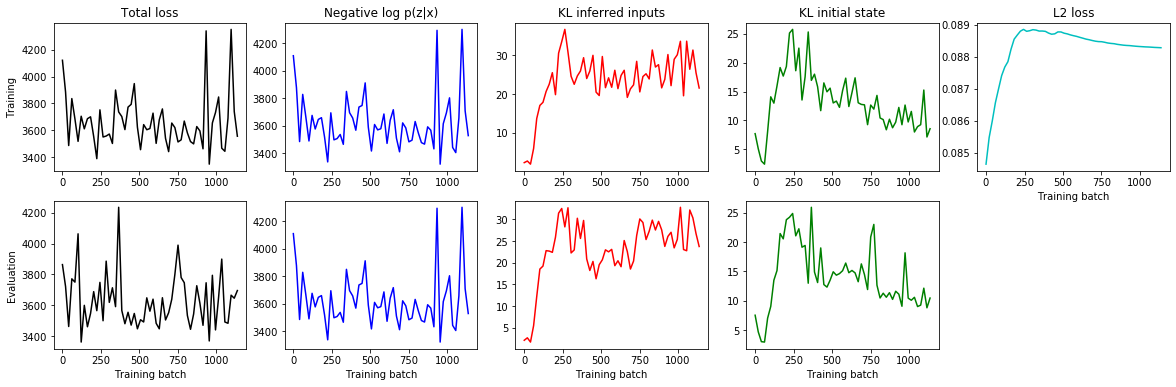

In [41]:
# Plot the training details
# x = onp.arange(0, num_batches, print_every)
x = onp.arange(len(opt_details['tlosses']['total'])) * num_batches / len(opt_details['tlosses']['total'])
plt.figure(figsize=(20,6), facecolor='white')
plt.subplot(251)
plt.plot(x, opt_details['tlosses']['total'], 'k')
plt.ylabel('Training')
plt.title('Total loss')
plt.subplot(252)
plt.plot(x, opt_details['tlosses']['nlog_p_xgz'], 'b')
plt.title('Negative log p(z|x)')
plt.subplot(253)
plt.plot(x, opt_details['tlosses']['kl_ii'], 'r')
plt.title('KL inferred inputs')
plt.subplot(254)
plt.plot(x, opt_details['tlosses']['kl_g0'], 'g')
plt.title('KL initial state')
plt.subplot(255)
plt.plot(x, opt_details['tlosses']['l2'], 'c')
plt.xlabel('Training batch')
plt.title('L2 loss')
plt.subplot(256)
plt.plot(x, opt_details['elosses']['total'], 'k')
plt.xlabel('Training batch')
plt.ylabel('Evaluation')
plt.subplot(257)
plt.plot(x, opt_details['tlosses']['nlog_p_xgz'], 'b')
plt.xlabel('Training batch')
plt.subplot(258)
plt.plot(x, opt_details['elosses']['kl_ii'], 'r')
plt.xlabel('Training batch')
plt.subplot(259)
plt.plot(x, opt_details['elosses']['kl_g0'], 'g')
plt.xlabel('Training batch');


### Save the result


In [ ]:
fname_uniquifier = datetime.datetime.now().strftime("%Y-%m-%d_%H:%M:%S")
network_fname = ('trained_params_' + rnn_type + '_' + task_type + '_' + \
                 fname_uniquifier + '.npz')
network_path = os.path.join(output_dir, network_fname)

# Note we are just using numpy save instead of h5 because the LFADS parameter 
# is nested dictionaries, something I couldn't get h5 to save down easily.
print("Saving parameters: ", network_path)
onp.savez(network_path, trained_params)


## Inspect Model